# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [49]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:

sex_index = features.columns.tolist().index('SEX_Female')
print(sex_index)
race_index = features.columns.tolist().index('RAC1P_Black or African American alone')
print(race_index)

54
55


In [59]:
#female = features.loc[features["SEX_Female"] == 1.0]
#male = features.loc[features["SEX_Female"] == 0.0]
#blacks = features.loc[features["RAC1P_Black or African American alone"] == 1.0]
#hites = features.loc[features["RAC1P_Black or African American alone"] == 0.0]

#print(male.shape[0])
#print(female.shape[0])
#rint(blacks.shape[0])
#print(whites.shape[0])
features["AGEP"].values.reshape(-1,1)

array([[21.],
       [65.],
       [33.],
       ...,
       [49.],
       [41.],
       [61.]])

In [62]:
from sklearn.preprocessing import StandardScaler

### Scale numerical values
new_features = features.copy()
scalar = StandardScaler()
scaler.fit(features["AGEP"].values.reshape(-1,1))
AGEP = scaler.transform(features["AGEP"].values.reshape(-1,1))
new_features["AGEP"] = AGEP
 

scalar = StandardScaler()
scaler.fit(features["WKHP"].values.reshape(-1,1))
WKHP = scaler.transform(features["WKHP"].values.reshape(-1,1))
new_features["WKHP"] = WKHP


scalar = StandardScaler()
scaler.fit(features["PWGTP"].values.reshape(-1,1))
PWGTP = scaler.transform(features["PWGTP"].values.reshape(-1,1))
new_features["PWGTP"] = PWGTP

### Train-Test split
X_train, X_test, y_train, y_test = train_test_split(new_features, labels, test_size=0.1, random_state=0)




In [65]:

### Get Females, Males, Blacks and whites 
### Should we further subdevide them??

female = X_test.loc[X_test["SEX_Female"] == 1.0]
male = X_test.loc[X_test["SEX_Female"] == 0.0]
blacks = X_test.loc[X_test["RAC1P_Black or African American alone"] == 1.0]
whites = X_test.loc[X_test["RAC1P_Black or African American alone"] == 0.0]

In [100]:
#######
# YOUR CODE
#######
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
#groups
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(random_state=0)


clf.fit(X_train,y_train)
#pipeline = Pipeline([('estimator', clf)])

#cv = KFold(n_splits=(100))
#scores = cross_val_score(pipeline, X_train, y_train, cv = cv)
#print(scores)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [8]:
import matplotlib.pyplot as plt

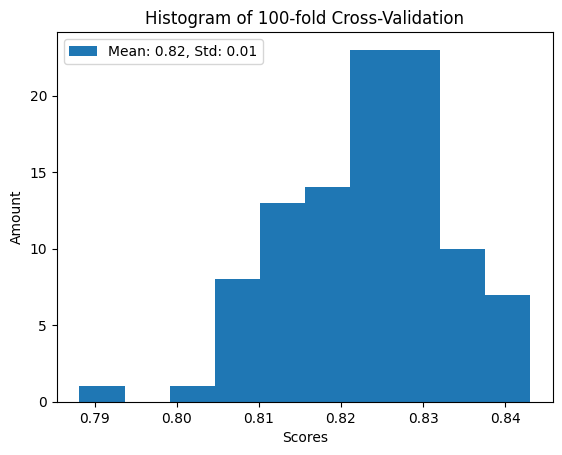

In [68]:
Mean = np.mean(scores)
Std = np.std(scores)
Mean ="%.2f" % Mean
Std ="%.2f" % Std
plt.hist(scores, label=f'Mean: {Mean}, Std: {Std}')
plt.xlabel("Scores")
plt.ylabel("Amount")
plt.title("Histogram of 100-fold Cross-Validation")
plt.legend()
plt.show()

In [97]:
### Get Females, Males, Blacks and whites 
### Should we further subdevide them??

female = X_test.loc[X_test["SEX_Female"] == 1.0]
male = X_test.loc[X_test["SEX_Female"] == 0.0]
blacks = X_test.loc[X_test["RAC1P_Black or African American alone"] == 1.0]
whites = X_test.loc[X_test["RAC1P_Black or African American alone"] == 0.0]

#print(list(female.index))

y_index = list(y_test.index)
def find_responding_y_test(data):
    resulting_list = []
    for i in list(data.index):
        if i in y_index:
            resulting_list.append(int(i))
    return resulting_list

f_resulting_index = find_responding_y_test(female)
y_test_female = y_test.loc[f_resulting_index]

m_resulting_index = find_responding_y_test(male)
y_test_male = y_test.loc[m_resulting_index]

b_resulting_index = find_responding_y_test(blacks)
y_test_black = y_test.loc[b_resulting_index]

w_resulting_index = find_responding_y_test(whites)
y_test_white = y_test.loc[w_resulting_index]


In [105]:
#print("Female", clf.score(female, y_test_female))
#print("Male", clf.score(male, y_test_male))
#print("Black", clf.score(blacks, y_test_black))
#print("White", clf.score(whites, y_test_white))

p_f = clf.predict(female)#, y_test_female)
p_m = clf.predict(male)#, y_test_male)
p_b = clf.predict(blacks)#, y_test_black)
p_w = clf.predict(whites)#, y_test_white)



